# Visualizing Damage Estimation in Gaza

This notebook provides a visual analysis of Synthetic Aperture Radar (SAR) data to assess and visualize potential damage in the Gaza Strip. SAR data, known for its ability to capture ground features and changes regardless of weather conditions or time of day, can be instrumental in identifying changes in infrastructure or land features following conflict or disasters.

```{caution}
The following damage assessment figures are based on preliminary estimates and have not been verified through field survey or satellite imagery. They do not reflect the final estimations by the [World Bank](https://www.worldbank.org/en/country/westbankandgaza).
```

```{note}
The results shown in this analysis only reflect the damages until **December 16, 2023**. As the team completes further analysis, the notebook will be updated. 
```

## Damage Assessment Map

You can now interact with this map by selecting/deselecting different damage layers to visualize where buildings are most impacted in the Gaza Strip. Upon visual inspection, you can see:

1. **Damage:** You can select and deselect the layers to see damages to roads, buildings and points of interest. The damage value ranges between 0 and 1 with 1 indicating higher levels of damage.
2. **Conflict:** You can select this layer to view areas wit reported events and fatalities.

<iframe width="100%" height="500px" src="https://studio.foursquare.com/public/26ba3dfb-0770-4cc6-b6fa-2ee2878580fc/embed" frameborder="0" allowfullscreen></iframe>

```{figure} ../../docs/images/logo.png
---
height: 0px
---
Damage assessment until December 16, 2023 in the Gaza Strip utilizing SAR imagery to evaluate the extent of destruction The damage map above is based on preliminary estimates and have not been verified through field survey or satellite imagery. It does not reflect the final estimations by the World Bank. Country borders or names do not necessarily reflect the World Bank Group's official position. This map is for illustrative purposes and does not imply the expression of any opinion on the part of the World Bank, concerning the legal status of any country or territory or concerning the delimitation of frontiers or boundaries.
```

## Summary Statistics

In the following section, we calculate summary statistics for each second-level administrative division. 

In [1]:
#!pip install pandas geopandas openpyxl palettable

In [2]:
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import FuncFormatter
from palettable.cartocolors.qualitative import Prism_10, Vivid_10
from palettable.tableau import ColorBlind_10, TableauMedium_10

%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

In [3]:
# read shapefiles
PSE = geopandas.read_file(
    "../../data/boundaries/pse_adm_pamop_20231019_shp/pse_admbnda_adm1_pamop_20231019.shp"
)
PSE = geopandas.read_file(
    "../../data/boundaries/pse_adm_pamop_20231019_shp/pse_admbnda_adm2_pamop_20231019.shp"
)
GAZA = PSE[PSE["ADM1_EN"] == "Gaza Strip"]

### Buildings

In the following section, we calculate summary statistics on **Buildings** for each second-level administrative division. 

In [4]:
BUILDINGS = geopandas.read_file(
    "../../data/damage_assessment/delivery5_16Dec2023/vectors/3sigma/damaged_OSM_buildings_16Dec2023_upd5.shp"
).to_crs("EPSG:4326")

BUILDINGS = geopandas.sjoin(BUILDINGS, GAZA)
BUILDINGS["type"] = BUILDINGS["type"].fillna("")

In [5]:
left = (
    BUILDINGS[BUILDINGS["_upd5mean"] >= 0.2]
    .value_counts(["ADM2_EN", "type"])
    .to_frame("damaged")
)
right = BUILDINGS.value_counts(["ADM2_EN", "type"]).to_frame("total")

df = pd.merge(left, right, on=["ADM2_EN", "type"]).reset_index()
df["perc"] = 100 * df["damaged"] / df["total"]

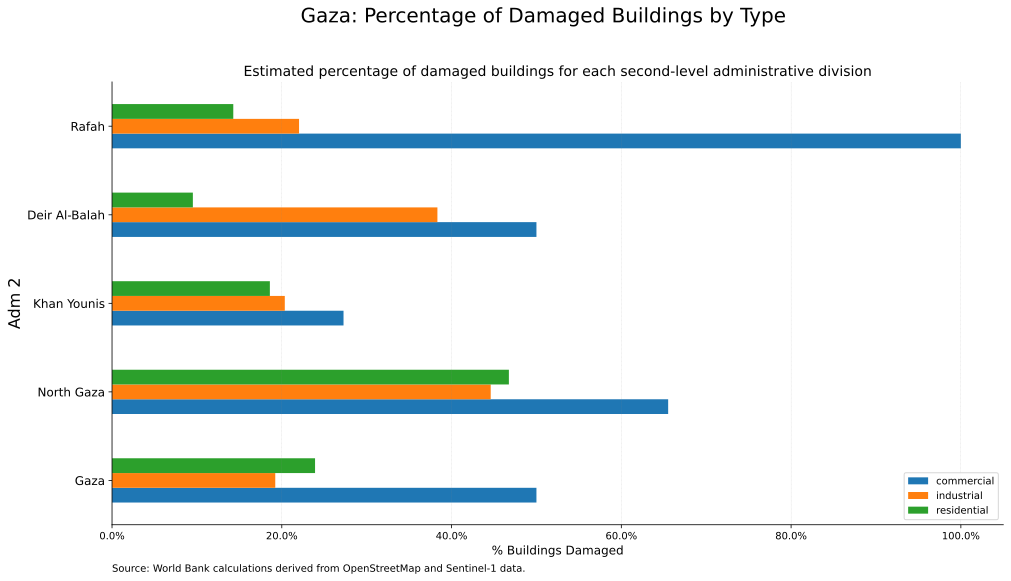

In [6]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.suptitle("Gaza: Percentage of Damaged Buildings by Type", y=1.01, fontsize=20)

df.pivot_table("perc", "ADM2_EN", "type")[
    ["commercial", "industrial", "residential"]
].plot(ax=ax, kind="barh")

# Add labels and customization
ax.set_xlabel("% Buildings Damaged", fontsize=12)

ax.set_ylabel("Adm 2", fontsize=16)
ax.set_yticklabels(df["ADM2_EN"].unique(), fontsize=12)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: "{}%".format(y)))

ax.grid(axis="x", linestyle="--", linewidth=0.25, color="gray", alpha=0.5)
ax.legend()

ax.set_title(
    "Estimated percentage of damaged buildings for each second-level administrative division",
    fontsize=14,
)
ax.text(
    0,
    -0.1,
    "Source: World Bank calculations derived from OpenStreetMap and Sentinel-1 data.",
    ha="left",
    va="center",
    transform=ax.transAxes,
    fontsize=10,
    color="black",
    weight="normal",
);

Alternatively, please see below the tabular data.

In [7]:
df.sort_values("damaged", ascending=False).style.format(
    {
        "perc": "{:,.2f}%",
    },
    precision=0,
)

,ADM2_EN,type,damaged,total,perc
0,Gaza,,13488,41804,32.26%
1,North Gaza,,7611,28591,26.62%
2,Khan Younis,,5665,40118,14.12%
3,Deir Al-Balah,,4027,28449,14.16%
4,Rafah,,3293,23752,13.86%
5,Gaza,industrial,207,464,44.61%
6,Gaza,apartments,170,346,49.13%
7,Gaza,ruins,128,195,65.64%
8,North Gaza,apartments,112,222,50.45%
9,Deir Al-Balah,residential,105,439,23.92%


```{figure} ../../docs/images/logo.png
---
height: 0px
---
Absolute and percentage damage assessment estimation for each second-level administrative division and building type.
```

### Points of Interest

In the following section, we calculate summary statistics on **Points of Interest** for each second-level administrative division. 

In [8]:
POI = geopandas.read_file(
    "../../data/damage_assessment/delivery5_16Dec2023/vectors/3sigma/damaged_pois_1_16Dec2023_upd5.shp",
).to_crs("EPSG:4326")

POI = geopandas.sjoin(POI, GAZA)
POI["fclass"] = POI["fclass"].fillna("")

In [9]:
def get_poi_classification(fclass):
    if fclass in [
        "school",
        "kindergarten",
        "university",
        "college",
    ]:
        return "Education"
    if fclass in [
        "tower",
        "wastewater_plant",
        "water_tower",
        "telephone",
        "water_well",
        "drinking_water",
        "recycling",
    ]:
        return "Infrastructure"
    if fclass in [
        "pharmacy",
        "dentist",
        "doctors",
        "hospital",
        "clinic",
        "nursing_home",
    ]:
        return "Health"
    if fclass in [
        "public_building",
        "police",
        "courthouse",
        "library",
        "monument",
        "post_office",
        "memorial",
        "community_centre",
        "town_hall",
        "museum",
        "arts_centre",
        "sports_centre",
        "tourist_info",
        "fire_station",
    ]:
        return "Public Amenities"

    elif fclass in [
        "clothes",
        "supermarket",
        "restaurant",
        "laundry",
        "cafe",
        "computer_shop",
        "convenience",
        "furniture_shop",
        "shoe_shop",
        "bakery",
        "hotel",
        "hairdresser",
        "fast_food",
        "bank",
        "viewpoint",
        "artwork",
        "picnic_site",
        "chalet",
        "caravan_site",
        "greengrocer",
        "beauty_shop",
        "car_dealership",
        "attraction",
        "pub",
        "waste_basket",
        "nightclub",
        "playground",
        "department_store",
        "outdoor_shop",
        "atm",
        "butcher",
        "car_rental",
        "doityourself",
        "guesthouse",
        "beverages",
        "theatre",
        "newsagent",
        "cinema",
        "mobile_phone_shop",
        "car_wash",
        "bookshop",
        "hostel",
        "sports_shop",
        "castle",
        "pitch",
        "car_sharing",
        "vending_machine",
        "food_court",
        "gift_shop",
        "camp_site",
        "veterinary",
        "post_box",
        "florist",
        "jeweller",
        "chemist",
        "motel",
        "alpine_hut",
        "mall",
        "kiosk",
        "bicycle_shop",
        "bench",
        "optician",
        "travel_agent",
        "biergarten",
        "toy_shop",
        "bar",
        "fountain",
        "archaeological",
        "shelter",
        "park",
        "stationery",
        "market_place",
        "zoo",
    ]:
        return "Places of Economic Activity"

In [10]:
POI["type"] = POI["fclass"].apply(get_poi_classification)

In [11]:
left = POI[POI["_upd5max"] >= 0.5].value_counts(["ADM2_EN", "type"]).to_frame("damaged")
right = POI.value_counts(["ADM2_EN", "type"]).to_frame("total")

df = pd.merge(left, right, on=["ADM2_EN", "type"]).reset_index()
df["perc"] = 100 * df["damaged"] / df["total"]

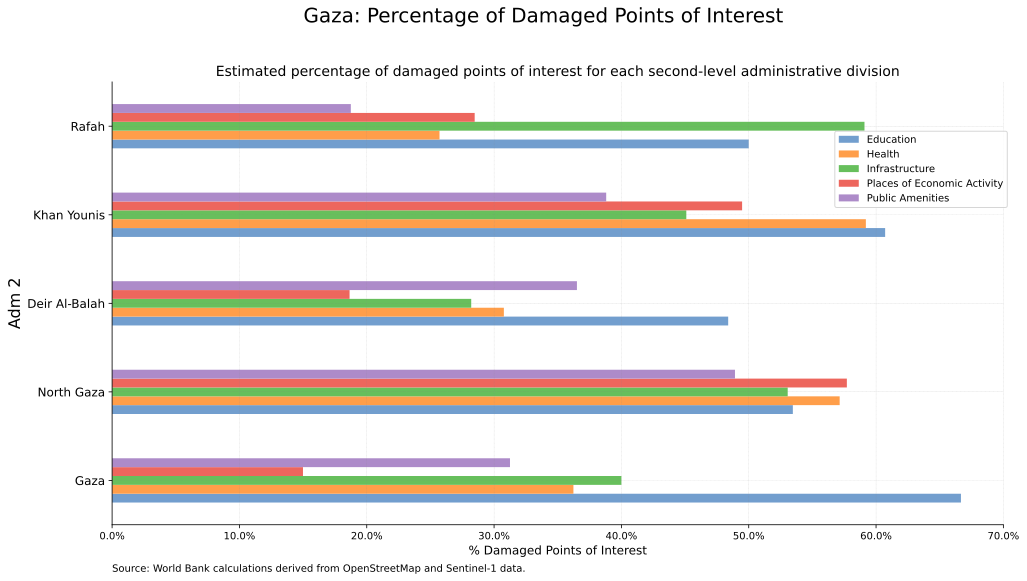

In [12]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.suptitle("Gaza: Percentage of Damaged Points of Interest", y=1.01, fontsize=20)

df.pivot_table("perc", "ADM2_EN", "type").plot(
    ax=ax, kind="barh", color=TableauMedium_10.mpl_colors
)

# Add labels and customization
ax.set_xlabel("% Damaged Points of Interest", fontsize=12)
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: "{}%".format(y)))
ax.set_ylabel("Adm 2", fontsize=16)
ax.set_yticklabels(df["ADM2_EN"].unique(), fontsize=12)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.grid(which="both", linestyle="--", linewidth=0.25, color="gray", alpha=0.5)
ax.legend(bbox_to_anchor=(1.01, 0.9))

ax.set_title(
    "Estimated percentage of damaged points of interest for each second-level administrative division",
    fontsize=14,
)
ax.text(
    0,
    -0.1,
    "Source: World Bank calculations derived from OpenStreetMap and Sentinel-1 data.",
    ha="left",
    va="center",
    transform=ax.transAxes,
    fontsize=10,
    color="black",
    weight="normal",
);

Alternatively, please see below the tabular data.

In [13]:
df.sort_values(["ADM2_EN", "type"]).style.format(
    {
        "perc": "{:,.2f}%",
    },
    precision=0,
)

,ADM2_EN,type,damaged,total,perc
19,Deir Al-Balah,Education,12,18,66.67%
12,Deir Al-Balah,Health,25,69,36.23%
22,Deir Al-Balah,Infrastructure,10,25,40.00%
3,Deir Al-Balah,Places of Economic Activity,85,567,14.99%
21,Deir Al-Balah,Public Amenities,10,32,31.25%
7,Gaza,Education,54,101,53.47%
2,Gaza,Health,196,343,57.14%
10,Gaza,Infrastructure,26,49,53.06%
0,Gaza,Places of Economic Activity,730,1265,57.71%
6,Gaza,Public Amenities,68,139,48.92%


```{figure} ../../docs/images/logo.png
---
height: 0px
---
Percentage damage assessment estimation for each second-level administrative division and points of interest.
```

### Roads

In the following section, we calculate summary statistics on **Roads** for each second-level administrative division. 

In [14]:
ROADS = geopandas.read_file(
    "../../data/damage_assessment/delivery5_16Dec2023/vectors/3sigma/damaged_roads_16Dec2023_upd5.shp"
).to_crs("EPSG:4326")

ROADS = geopandas.sjoin(ROADS, GAZA)

In [15]:
mapper = {
    "track": "Tracks",
    "unclassified": "Unclassified",
    "residential": "Other",
    "tertiary": "Tertiary",
    "service": "Other",
    "secondary": "Secondary",
    "track_grade3": "Tracks",
    "track_grade5": "Tracks",
    "trunk": "Other",
    "path": "Other",
    "track_grade4": "Tracks",
    "primary": "Primary",
    "secondary_link": "Secondary",
    "footway": "Other",
    "steps": "Other",
    "tertiary_link": "Tertiary",
    "trunk_link": "Other",
    "pedestrian": "Other",
    "primary_link": "Primary",
    "living_street": "Other",
    "unknown": "Unclassified",
    "track_grade1": "Tracks",
}
ROADS["type"] = ROADS["fclass"].replace(mapper)

In [16]:
left = (
    ROADS[ROADS["_upd5max"] >= 0.5]
    .value_counts(["ADM2_EN", "type"])
    .to_frame("damaged")
)
right = ROADS.value_counts(["ADM2_EN", "type"]).to_frame("total")

df = pd.merge(left, right, on=["ADM2_EN", "type"]).reset_index()
df["perc"] = 100 * df["damaged"] / df["total"]

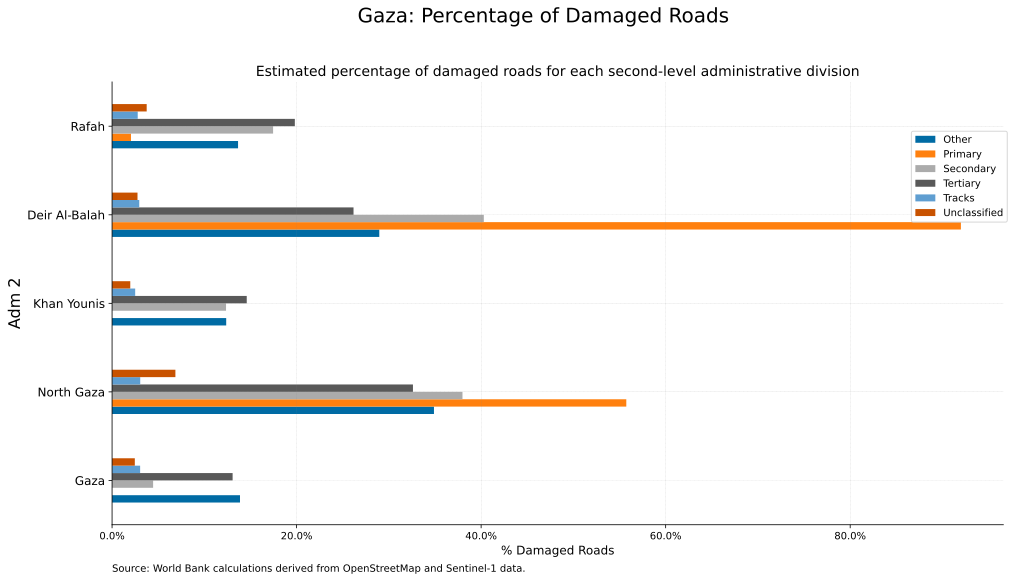

In [17]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.suptitle("Gaza: Percentage of Damaged Roads", y=1.01, fontsize=20)

df.pivot_table("perc", "ADM2_EN", "type").plot(
    ax=ax, kind="barh", color=ColorBlind_10.mpl_colors
)

# Add labels and customization
ax.set_xlabel("% Damaged Roads", fontsize=12)
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: "{}%".format(y)))
ax.set_ylabel("Adm 2", fontsize=16)
ax.set_yticklabels(df["ADM2_EN"].unique(), fontsize=12)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.grid(which="both", linestyle="--", linewidth=0.25, color="gray", alpha=0.5)
ax.legend(bbox_to_anchor=(1.01, 0.9))

ax.set_title(
    "Estimated percentage of damaged roads for each second-level administrative division",
    fontsize=14,
)
ax.text(
    0,
    -0.1,
    "Source: World Bank calculations derived from OpenStreetMap and Sentinel-1 data.",
    ha="left",
    va="center",
    transform=ax.transAxes,
    fontsize=10,
    color="black",
    weight="normal",
);

```{figure} ../../docs/images/logo.png
---
height: 0px
---
Percentage damage assessment estimation for each second-level administrative division and road type.
```

Alternatively, please see below the tabular data.

In [18]:
df.sort_values(["ADM2_EN", "type"]).style.format(
    {
        "perc": "{:,.2f}%",
    },
    precision=0,
)

,ADM2_EN,type,damaged,total,perc
3,Deir Al-Balah,Other,7346,52980,13.87%
24,Deir Al-Balah,Secondary,72,1618,4.45%
15,Deir Al-Balah,Tertiary,1024,7837,13.07%
11,Deir Al-Balah,Tracks,1063,34942,3.04%
23,Deir Al-Balah,Unclassified,94,3812,2.47%
0,Gaza,Other,24307,69670,34.89%
14,Gaza,Primary,1035,1857,55.74%
5,Gaza,Secondary,4450,11717,37.98%
6,Gaza,Tertiary,2167,6645,32.61%
13,Gaza,Tracks,1039,34043,3.05%
